<div class="usecase-title">Block Energy Prediction Model</div>

<div class="usecase-authors"><b>Authored by: </b> Thomas Warren</div>

<div class="usecase-duration"><b>Duration:</b> 240 mins</div>

<div class="usecase-level-skill">
    <div class="usecase-level"><b>Level: </b>Advanced</div>
    <div class="usecase-skill"><b>Pre-requisite Skills: </b>Deep Learning, Python, Data Wrangling</div>
</div>

<div class="usecase-section-header">Scenario</div>

I am a CoM Planner who wants to understand the energy consumption of a new development early in the application stages before the concept designs are completed. 

<div class="usecase-section-header">What this use case will teach you</div>

- The utility and limitations of deep learning on block-level data;
- Energy approximations for city blocks; and
- Future direction for modelling and data collection.

<div class="usecase-section-header">Block Level Energy Consumption</div>

Energy consumption is a key point of interest in the age of the climate crisis. Understanding how cities use energy, especially how differing activities and use typologies affect energy consumption, is critical to design sustainable urban areas. However, this understanding is often obscured by the development process itself. Early stages of design do not provide the granularity needed to accurately predict an individual spaces energy use (e.g. a retail development could include an electronics store, a fast food outlet, or a clothing store). By 'zooming out' and assessing the CoM environment from a macro level, in this case the city block, broad predictions can be made earlier in the process, providing insight during the approval process such as constraints on use or advocacy for specific designs. 

__Note__: The energy levels used in this model are based on 2015 predictions, not direct readings of the buildings/blocks. As such, this model is not trained off 'ground truth,' and only serves as an example of applications for deep learning in the planning space.

**Designing Prediction Model**

Below is the relevant code for generating the block level energy use within the City of Melbourne. It utilised 3 available datasets:

 * Block for Census of Land Use and Employment;
 * Block level energy consumption (modelling on building attributes) - 2021 projection business as usual; and
 * Floor space per CLUE industry for blocks.

The rationale is as the floor space for industry is identified by Block ID, the energy levels are by geospatial data, and the census includes both the Block ID and geospatial coordinates, by joining these three datasets the energy and floor space use can be connected.
 

__Discussion of Results__

As noted above, the energy usage is synthetic data, not ground truth. This has a profound impact on the results. Through several iterations of the model, the pattern was determined almost immediately. This is as a result of the simplified model to create the energy data, whereby floor space use and energy use is a linear multiplier. As a result, the model almost determines in the first epoch of training, reducing the loss to near zero. 

Despite the simplicity of the results, the model remains relevant. Real world readings will not present such a simple relationship and as such the use of a deep learning model remains relevant. These allow mapping of non-linear or obvious relationships within the data. The methodology for assessment, including model complexity, learning rate, and evaluation metrics, are suitable for solving this issue. 

Primary actionable insights for CoM are:

* Integrate capture of energy levels within municipality through outside agencies;
* Consider use of deep learning models for planning applications, in particular energy usage as this is 'low hanging fruit' for data modelling due to the ubiquity of the data.

In [1]:
# Dependencies
import warnings
warnings.filterwarnings("ignore")

import requests
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
from io import StringIO
import geopandas as gpd
from shapely import wkt
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler, PowerTransformer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.losses import Huber


In [2]:
#Function to collect data
def collect_data(dataset_id):
    base_url = 'https://data.melbourne.vic.gov.au/api/explore/v2.1/catalog/datasets/'
    dataset_id = dataset_id
    format = 'csv'

    url = f'{base_url}{dataset_id}/exports/{format}'
    params = {
        'select': '*',
        'limit': -1,  # all records
        'lang': 'en',
        'timezone': 'UTC',
        #'api_key': apikey  #use if use datasets API_key permissions
    }

    # GET request
    response = requests.get(url, params=params)

    if response.status_code == 200:
        # StringIO to read the CSV data
        url_content = response.content.decode('utf-8')
        dataset = pd.read_csv(StringIO(url_content), delimiter=';')
        return dataset
    else:
        print(f'Request failed with status code {response.status_code}')

In [3]:
# Set dataset_id to query for the API call dataset name
dataset_id_1 = 'block-level-energy-consumption-modelled-on-building-attributes-2021-projection-b'
dataset_id_2 = 'blocks-for-census-of-land-use-and-employment-clue'
dataset_id_3 = 'floor-space-by-block-by-clue-industry'

# Save dataset to df varaible
energy_df = collect_data(dataset_id_1)
block_id_df = collect_data(dataset_id_2)
block_use_df = collect_data(dataset_id_3)

# Check number of records in df
print(f'The dataset 1 contains {len(energy_df)} records.')
print(f'The dataset 2 contains {len(block_id_df)} records.')
print(f'The dataset 3 contains {len(block_use_df)} records.')

The dataset 1 contains 640 records.
The dataset 2 contains 606 records.
The dataset 3 contains 12394 records.


**Data Preprocessing**

To prepare the data for modelling, several steps needed to be taken:

* As the block use dataset includes multiple years, this will be filtered to 2021 (the year of interest for training) only. 
* The rows with NaN values (data is missing the floor use for each type is assumed to be 0) need to be dealt with. This includes summing total floor space, and dropping rows without floor space information.
* The dataframes will then be converted to geodataframes, to allow them to be spatially joined. This allows the block id to accurately reference the energy dataframe.

Following data preprocessing, the dataframe is assessed. It is noteworthy that over a hundred rows were missing floor space values which needed to be omitted. Further, the data is highly skewed. This needs to be addressed.

In [4]:
# Filter for 2021 data only
block_use_df = block_use_df[block_use_df['census_year'] == 2021]

In [5]:
# Clean empty values
block_use_df.fillna(0, inplace=True)

In [6]:
# Function to convert DataFrame to GeoDataFrame by converting geo_point_2d to Points
def convert_to_geopandas(df, point_column):
    # Convert string coordinates to Point geometry
    df['geometry'] = df[point_column].apply(lambda x: wkt.loads(f"POINT({x.split(',')[1]} {x.split(',')[0]})"))
    gdf = gpd.GeoDataFrame(df, geometry='geometry')
    return gdf

In [7]:
# Convert dataframes to geodataframes
gdf_blocks = convert_to_geopandas(block_id_df, 'geo_point_2d')
gdf_energy = convert_to_geopandas(energy_df, 'geo_point_2d')

In [8]:
# Set the CRS for both GeoDataFrames to WGS 84
gdf_energy.set_crs(epsg=4326, inplace=True)
gdf_blocks.set_crs(epsg=4326, inplace=True)

,geo_point_2d,geo_shape,block_id,clue_area,geometry
0,"-37.788517214796904, 144.9421522923356","{""coordinates"": [[[144.9421360326, -37.7875659...",925,Parkville,POINT (144.94215 -37.78852)
1,"-37.78752314475404, 144.9428068448982","{""coordinates"": [[[144.9421360326, -37.7875659...",924,Parkville,POINT (144.94281 -37.78752)
2,"-37.78035632811396, 144.94536433435934","{""coordinates"": [[[144.9425926939, -37.7787229...",930,Parkville,POINT (144.94536 -37.78036)
3,"-37.80720183148242, 144.94336441344424","{""coordinates"": [[[144.9427148261, -37.8073238...",412,West Melbourne (Residential),POINT (144.94336 -37.80720)
4,"-37.806706331914484, 144.94240782994808","{""coordinates"": [[[144.9427148261, -37.8073238...",410,West Melbourne (Residential),POINT (144.94241 -37.80671)
...,...,...,...,...,...
601,"-37.788167405860435, 144.92542680884995","{""coordinates"": [[[144.9246397569, -37.7887978...",2502,Kensington,POINT (144.92543 -37.78817)
602,"-37.78839510691857, 144.92690534228524","{""coordinates"": [[[144.927147239, -37.78853838...",2506,Kensington,POINT (144.92691 -37.78840)
603,"-37.788736986243904, 144.94077827466833","{""coordinates"": [[[144.9421572489, -37.7893851...",2382,North Melbourne,POINT (144.94078 -37.78874)
604,"-37.79303223759281, 144.9399716568005","{""coordinates"": [[[144.9394523527, -37.7922270...",2388,North Melbourne,POINT (144.93997 -37.79303)


In [9]:
# Perform the nearest neighbor join
gdf_join_1 = gpd.sjoin_nearest(gdf_energy, gdf_blocks, how='left', distance_col='distance')


In [10]:
# Merge the block_use_df with the gdf_join_1 for the final dataset with all the information
df = pd.merge(gdf_join_1, block_use_df, on='block_id', how='left')

In [13]:
# Drop columns with less than three values
df = df.loc[:, (df != 0).sum() >= 3]

In [14]:
# List of columns from which to sum values
columns_to_sum = [
    'accommodation', 'admin_and_support_services', 'agriculture_and_mining', 'arts_and_recreation_services',
    'business_services', 'construction', 'education_and_training', 'electricity_gas_water_and_waste_services',
    'finance_and_insurance', 'food_and_beverage_services', 'health_care_and_social_assistance',
    'information_media_and_telecommunications', 'manufacturing', 'other_services',
    'public_administration_and_safety', 'real_estate_services', 'rental_and_hiring_services',
    'retail_trade', 'transport_postal_and_storage', 'wholesale_trade'
]

# Calculating the sum of the specified columns and storing in a new column
df['sum_of_columns'] = df[columns_to_sum].sum(axis=1)

# Replace zeros in 'total_floor_space_in_block' with the sum from 'sum_of_columns'
df.loc[df['total_floor_space_in_block'] == 0, 'total_floor_space_in_block'] = df['sum_of_columns']

# Drop the 'sum_of_columns' column
df.drop('sum_of_columns', axis=1, inplace=True)

# Drop rows with 'total_floor_space_in_block' equal to zero after summing other spaces
df = df[df['total_floor_space_in_block'] != 0]

In [16]:
non_zero_counts = df.astype(bool).sum()
print(non_zero_counts)

geo_point_2d_left                           453
geo_shape_left                              453
comm                                        393
num_b_prop                                  426
resi                                        378
total                                       419
geometry                                    453
index_right                                 453
geo_point_2d_right                          453
geo_shape_right                             453
block_id                                    453
clue_area                                   453
distance                                    453
census_year                                 453
clue_small_area                             453
accommodation                                51
admin_and_support_services                   75
agriculture_and_mining                        5
arts_and_recreation_services                101
business_services                           193
construction                            

In [17]:
# Drop unnecessary columns
df = df.drop(['geo_point_2d_left', 'geo_shape_left', 'comm','num_b_prop','resi','geometry','index_right','geo_point_2d_right', 'geo_shape_right','distance','census_year','clue_area','clue_small_area'], axis=1)

# Set 'block_id' as index
df.index = df['block_id']
df = df.drop('block_id', axis=1)

(array([197.,  62.,  47.,  27.,  15.,  13.,  13.,  13.,   6.,   4.,   3.,
          5.,   7.,   3.,   3.,   2.,   5.,   2.,   4.,   2.,   1.,   1.,
          2.,   1.,   2.,   0.,   1.,   2.,   0.,   2.,   1.,   0.,   2.,
          0.,   0.,   1.,   0.,   2.,   0.,   0.,   0.,   1.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   1.]),
 array([     0.        ,   2065.05475732,   4130.10951464,   6195.16427196,
          8260.21902928,  10325.2737866 ,  12390.32854392,  14455.38330124,
         16520.43805856,  18585.49281588,  20650.5475732 ,  22715.60233052,
         24780.65708784,  26845.71184516,  28910.76660248,  30975.8213598 ,
         33040.87611712,  35105.93087444,  37170.98563176,  39236.04038908,
         41301.0951464 ,  43366.14990372,  45431.20466104,  47496.25941836,
         49561.31417568,  51626.368933  ,  53691.42369032,  55756.47844764,
         57821.53320496,  59886.58796228,  61951.6427196 ,  64016.69747692,
         66081.75223424,  68146.80699156,  70211.8

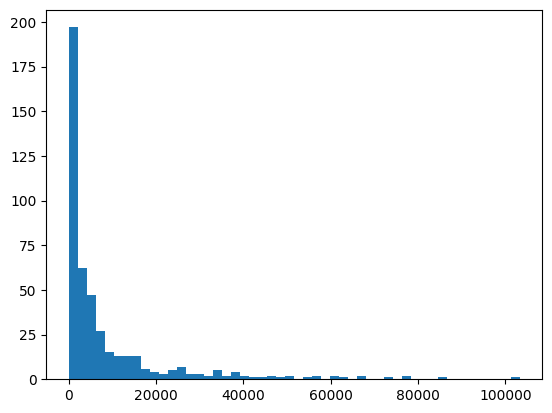

In [22]:
plt.hist(df['total'], bins = 50)

(array([273.,  86.,  33.,  16.,   4.,   7.,   5.,   2.,   5.,   1.,   4.,
          2.,   8.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   1.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   2.]),
 array([2.06000000e+02, 3.98978664e+04, 7.95897328e+04, 1.19281599e+05,
        1.58973466e+05, 1.98665332e+05, 2.38357198e+05, 2.78049065e+05,
        3.17740931e+05, 3.57432798e+05, 3.97124664e+05, 4.36816530e+05,
        4.76508397e+05, 5.16200263e+05, 5.55892130e+05, 5.95583996e+05,
        6.35275862e+05, 6.74967729e+05, 7.14659595e+05, 7.54351462e+05,
        7.94043328e+05, 8.33735194e+05, 8.73427061e+05, 9.13118927e+05,
        9.52810794e+05, 9.92502660e+05, 1.03219453e+06, 1.07188639e+06,
        1.11157826e+06, 1.15127013e+06, 1.19096199e+06, 1.23065386e+06,
        1.27034572e+06, 1.31003759e+06, 1.34972946e+06, 1.38942132e+06,
        1.

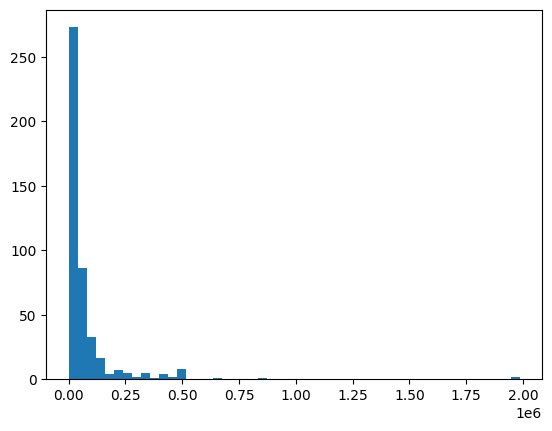

In [23]:
plt.hist(df['total_floor_space_in_block'], bins = 50)

## Modelling ##

Several points are important to note in the modelling step:

* As seen above, the histograms of the energy use and total floor space in block variables revealed a right-skewed distribution. Such distributions can lead to suboptimal performance in machine learning models, which typically assume a normal distribution of input variables. To address this, a logarithmic transformation was applied to the target variable.
* Given the presence of outliers, as suggested by the long tail of the histograms, a robust loss function, Huber loss, was chosen. Huber loss is less sensitive to outliers than traditional mean squared error because it treats error as squared only for small values, and linearly for larger errors, thus reducing the influence of outliers.
* Machine learning models benefit from feature scaling, which ensures that all features contribute equally to the model's performance. RobustScaler was selected over StandardScaler for its robustness against outliers, as it scales features using statistics that are robust to outliers.
* To optimise the training process, a learning rate scheduler was employed. It maintains a higher learning rate for initial epochs to allow for rapid learning and then reduces the learning rate as training progresses to fine-tune the model weights. This helps in converging to a better model by allowing more substantial updates to weights initially and smaller, more precise updates in later training phases.
* After the logarithmic transformation, a PowerTransformer was applied to the target variable to make its distribution more Gaussian. This step improves algorithms that are sensitive to the distribution of the data and helps in improving model predictions.

Epoch 1/5


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 48212.4766 - mae: 48212.8789 - val_loss: 0.5560 - val_mae: 0.9653 - learning_rate: 0.1000
Epoch 2/5
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4014 - mae: 0.7555 - val_loss: 0.4973 - val_mae: 0.8806 - learning_rate: 0.1000
Epoch 3/5
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4162 - mae: 0.7714 - val_loss: 0.4885 - val_mae: 0.8673 - learning_rate: 0.1000
Epoch 4/5
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3432 - mae: 0.6867 - val_loss: 0.5007 - val_mae: 0.8858 - learning_rate: 0.1000
Epoch 5/5
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4242 - mae: 0.7909 - val_loss: 0.4974 - val_mae: 0.8808 - learning_rate: 0.1000
2/2 - 0s - 9ms/step - loss: 0.4269 - mae: 0.7848
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


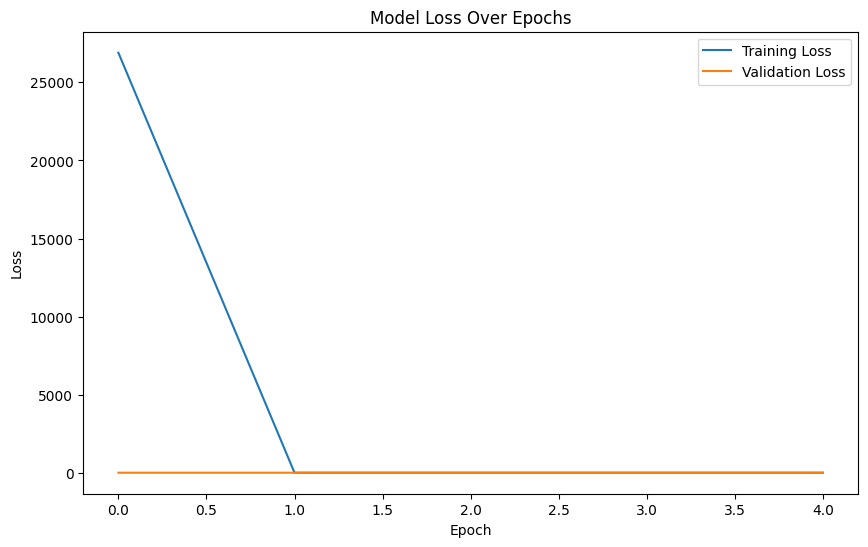

In [21]:
# Apply a log transformation to the target variable to mitigate skewness
y_log_transformed = np.log1p(df['total'])

# Initialize PowerTransformer for the target variable
power_transformer = PowerTransformer()
y_transformed = power_transformer.fit_transform(y_log_transformed.values.reshape(-1, 1)).flatten()

# Split the data into features and target
X = df.drop('total', axis=1)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_transformed, test_size=0.1, random_state=42)

# Initialize RobustScaler for features
scaler = RobustScaler()

# Fit the scaler on the training data and transform both training and testing data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Learning Rate Scheduler function
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

# Build the neural network model with increased complexity
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)),  # Input layer
    Dense(64, activation='relu'),                                           # Hidden layer 1
    Dense(64, activation='relu'),                                           # Hidden layer 2
    Dense(32, activation='relu'),                                           # Hidden layer 3
    Dense(1)                                                                # Output layer
])

# Compile the model with Huber loss, which is robust to outliers
model.compile(optimizer=Adam(learning_rate=0.1), loss=Huber(), metrics=['mae'])

# Create Learning Rate Scheduler callback
lr_scheduler = LearningRateScheduler(scheduler)

# Train the model with the learning rate scheduler callback
history = model.fit(X_train_scaled, y_train, epochs=5, validation_split=0.2, callbacks=[lr_scheduler], verbose=1)

# Evaluate the model on the test set
test_results = model.evaluate(X_test_scaled, y_test, verbose=2)

# Invert the transformation for evaluation and interpretation of results
y_pred_transformed = model.predict(X_test_scaled)
y_pred = power_transformer.inverse_transform(y_pred_transformed)
y_pred = np.expm1(y_pred)

# Plotting the training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()